In this notebook we consider the estimation of the distribution of the confusion matrix

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import itertools as it
from scipy.stats import levene
import matplotlib.pyplot as plt

from mmur.simulators import LAlgorithm
from mmur.generators import BlobGenerator

Assumed is a Gaussian distribution for both classes. Dataset consists of two Gaussian blobs, with tunable covariance between the features

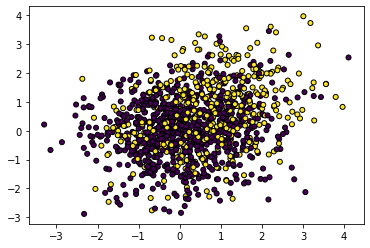

In [3]:
generator = BlobGenerator(
    train_size=1000,
    test_size=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    weights=[0.8, 0.2],
    flip_y=0.2,
    class_d=2.0,
    scale=1.0,
    shuffle=False,
    random_state=123,
    var=1,
    cov=0,
    random_imbalance=False)
X, y = generator.make_classification()

generator.plot_blobs(X, y, scatter=True, contour=False)

First, we simulate the true confusion matrix distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size.
This is the same as the true distribution of the holdout estimator. From this we can also derive the true distributions of the performance metrics.

Several components are added to resemble noise present in a practical setting. 

<b>random_imbalance</b>: given the class balance set by weights, the number observations with a certain label is sampled from a binomial distribution (multinomial for n_classes>2). Optional is to set a beta prior to this binomial distribution to increase the variance of the draws.

<b>flip_y</b>: fraction of observations that is susceptible to being flipped. If an observation is susceptible it takes any of the labels with equal probability

<b>fix_init</b>: fixes the seed for the learning algorithm

In [3]:
def sim_CMs(train_size=5000, test_size=1000, weights=[0.8, 0.2], model_name='LR', class_d=2.0, random_imbalance=False, flip_y=0, imbalance_prior_a=None, imbalance_prior_b=None, tau=0.5, n_runs=5000, n_jobs=-2, random_state=123, fixed_data=False,data_seed=None):
    """Function to simulate multiple confusion matrices, either on independent train/test set samples, or using a fixed train/test sample.

    Parameters
    ----------
    train_size : int, optional
        Size of the train sample, by default 5000
    test_size : int, optional
        Size of the test sample, by default 1000
    weights : list, optional
        Mean class frequencies, by default [0.8, 0.2]
    model_name : str, optional
        Represents the name of the machine learning model, by default 'LR' for logistic regression
    class_d : float, optional
        Euclidean distance between the gaussian blob centers, by default 2.0
    random_imbalance : bool, optional
        Whether to have varying class frequencies per sample draw, by default False
    flip_y : int, optional
        Probabilility of a label being flipped, by default 0
    imbalance_prior_a : _type_, optional
        Prior parameter a for additional randomness in class frequencies, by default None
    imbalance_prior_b : _type_, optional
        Prior parameter b for additional randomness in class frequencies, by default None
    tau : float, optional
        Classification threshold, by default 0.5
    n_runs : int, optional
        Number of runs to perform, corresponds to number of output confusion matrices, by default 5000
    n_jobs : int, optional
        Number of threads for parallization, by default -2 (uses every CPU core except 1)
    random_state : int, optional
        random state to generate seeds for all the runs, by default 123
    fixed_data : bool, optional
        Whether to use a fixed dataset for each run, by default False
    data_seed : _type_, optional
        If `fixed_data`, seed for the data sample, by default None

    Returns
    -------
    _type_
        _description_
    """

    data_kwargs = {'train_size' : train_size, 'test_size' : test_size, 'weights':weights, 'class_d':class_d, 'random_imbalance': random_imbalance, 'flip_y' : flip_y, 'imbalance_prior_a': imbalance_prior_a, 'imbalance_prior_b' : imbalance_prior_b}

    init_kwargs = {} # To be specified
    fit_kwargs = {} # To be specified

    kwargs = {'data_kwargs' : data_kwargs, 'init_kwargs' : init_kwargs, 'fit_kwargs' : fit_kwargs}
    la = LAlgorithm(model_name,BlobGenerator,**kwargs)
    cms = la.sim_true_cms(n_runs,tau,n_jobs,random_state,fixed_data=fixed_data,data_seed=data_seed)
    return cms

def create_and_plot(train_size, test_size, weights, flip_y, random_imbalance, imbalance_prior_a=None, imbalance_prior_b=None, contour=True, scatter=True):
    generator = BlobGenerator(
        train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        random_imbalance=random_imbalance,
        imbalance_prior_a=imbalance_prior_a,
        imbalance_prior_b=imbalance_prior_b,
        random_state=gen_seed,
    )
    X, y = generator.make_classification()
    generator.plot_blobs(X, y, contour=contour, scatter=scatter)


def cms_to_precision(cms):
        """
        Computes the precisions based on a list of confusion matrices

        Parameters
        cms : list
            List of (2 by 2) confusion matrices, where each confusion matrix is a list with two sublists
            of length 2, containing the counts. [[true negatives,false positives],[false negatives,true positives]]

        Returns
        TP/(TP+FP) : ndarray
            1D numpy array of precisions
        """

        cms_array = np.array(cms)
        TP = cms_array[:, 3]
        FP = cms_array[:, 1]
        return TP/(TP+FP)

def cms_to_recall(cms):
    """
    Computes the recalls based on a list of confusion matrices

    Parameters
    cms : list
        List of(2 by 2) confusion matrices, where each confusion matrix is a list with two sublists
        of length 2, containing the counts. [[true negatives, false positives], [false negatives, true positives]]

    Returns
    TP/(TP+FN) : ndarray
        Vector of recalls
    """
    cms_array = np.array(cms)
    TP = cms_array[:, 3]
    FN = cms_array[:, 2]
    return TP/(TP+FN)

def CM_dict_to_prec(CM_dict):
    """Function to convert dictionary of confusion matrices to dictionary of precisions

    Parameters
    ----------
    CM_dict : dict containing np.ndarrays
        each value is a np.ndarray of shape (n,4)

    Returns
    -------
    dict
        identical keys, contain an np.ndarray for the same keys but now with precisions
    """
    return {k: cms_to_precision(v) for k, v in CM_dict.items()}

In [4]:
def run_params(params, exp_nr, noise_name, comb_type='zip',save=True, verbose=False):
    """
    Runs experiments to evaluate the confusion matrix' distribution for multiple parameter settings.

    Parameters
    ----------
    params : dict
        Dictionary containing the names of the parameters with as dict values the parameter settings to evaluate.
        Allows for both iterable and non-iterable dict values.
    exp_nr : int or str
        Experiment number, used for naming the file with results.
    noise_name : str
        Name of the type of noise that is investigated, used to name output file
    comb_type : str, optional
        The combination type of the parameters, either iterate over the zipped lists ('pairings'), or go through all combinations of the parameters, by default 'pairings'
    save : bool, optional
        Indicates whether to save the output into a pkl file, by default True
    verbose : bool, optional
        Whether to print the combination that is being computed at each iteration, by default False

    Returns
    -------
    dict
        Dictionary of results, of form '...'
    """

    # Collect the parameter that have constant values
    constant_dict = {}
    keys = list(params.keys())
    values = list(params.values())
    for k, v in zip(keys, values):
        if not isinstance(v, list):
            constant_dict[k] = params.pop(k)

    if comb_type == 'zip':
        combis = list(zip(*params.values()))
    elif comb_type == 'product':
        combis = list(it.product(*params.values()))
    else:
        raise ValueError('`comb_type` must be either `zip` or `product`')

    print('Varied parameter values: ',params)
    print('Constant parameter values: ',constant_dict)

    results = {}
    for i,values in enumerate(combis,1):
        if verbose:
            print(
                f'Combination {i} out of {len(combis)} being tried: {list(zip(list(params), values))}')
        result_key = ', '.join(['='.join([p, str(v)])
                            for p, v in zip(list(params), values)])
        results[result_key] = sim_CMs(**constant_dict,**dict(zip(params, values))) # input the constants and the varying parameter values using two dictionaries

    if save:
        with open(f'exp{exp_nr}_{noise_name}_noise_cm.pkl', 'wb') as f:
            pkl.dump(results, f)
    return results

In [5]:
from scipy.stats import levene

def df_cols_levene(df):
    pvalues = []
    var1 = []
    var2 = []
    cols = []
    for col1,col2 in it.combinations(df.columns,2):
        var1.append(np.var(df[col1]))
        var2.append(np.var(df[col2]))
        pvalues.append(levene(df[col1], df[col2]).pvalue)
        cols.append(col1 + ' vs ' +  col2)

    data = np.round(np.array([pvalues,var1,var2]),6).T
    return pd.DataFrame(data,index=cols,columns=["p-value levene's test",'Variance 1', 'Variance 2'])

#### 1. Looking at the effect of sampling noise for the train and test set separately

In [7]:
# First consider only the effect of sampling noise for varying train en test sizes. Compute all combinations

params = {
    'train_size':[int(1e6),5000,500],
    'test_size':[int(1e6),1000,100],
    'n_runs' : 1000
}

results_smpl = run_params(params,1,'sampling',comb_type='product',save=True,verbose=False)

Varied parameter values:  {'train_size': [1000000, 5000, 500], 'test_size': [1000000, 1000, 100]}
Constant parameter values:  {'n_runs': 1000}


In [8]:
def print_mean_std(values, decimals=3):
    print("Mean precision of: ", np.round(np.mean(values), decimals=decimals))
    print("Std of: ", np.round(np.std(values), decimals=decimals))

print_mean_std(cms_to_precision(
    results_smpl['train_size=1000000, test_size=1000000']))
# We observe that the precision converges to 0.774 for large train and test sets

Mean precision of:  0.774
Std of:  0.001


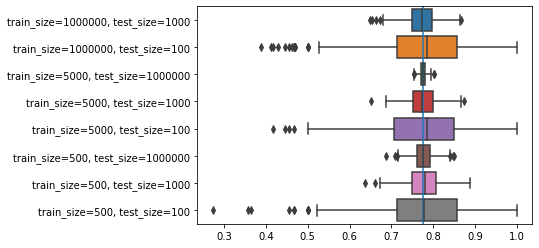

In [9]:
precs_dict = {k: cms_to_precision(v) for k, v in results_smpl.items()}
min_var = precs_dict.pop('train_size=1000000, test_size=1000000', None)
sns.boxplot(data=pd.DataFrame(precs_dict), orient = 'h')
plt.axvline(np.mean(min_var))

In [10]:
# Levene test for difference in variance
df_cols_levene(pd.DataFrame(precs_dict))

,p-value levene's test,Variance 1,Variance 2
"train_size=1000000, test_size=1000 vs train_size=1000000, test_size=100",0.000000,0.001174,0.011761
"train_size=1000000, test_size=1000 vs train_size=5000, test_size=1000000",0.000000,0.001174,0.000055
"train_size=1000000, test_size=1000 vs train_size=5000, test_size=1000",0.832854,0.001174,0.001124
"train_size=1000000, test_size=1000 vs train_size=5000, test_size=100",0.000000,0.001174,0.011152
"train_size=1000000, test_size=1000 vs train_size=500, test_size=1000000",0.000000,0.001174,0.000542
"train_size=1000000, test_size=1000 vs train_size=500, test_size=1000",0.000004,0.001174,0.001568
"train_size=1000000, test_size=1000 vs train_size=500, test_size=100",0.000000,0.001174,0.011527
"train_size=1000000, test_size=100 vs train_size=5000, test_size=1000000",0.000000,0.011761,0.000055
"train_size=1000000, test_size=100 vs train_size=5000, test_size=1000",0.000000,0.011761,0.001124
"train_size=1000000, test_size=100 vs train_size=5000, test_size=100",0.610853,0.011761,0.011152


#### 2. Simulate precision distribution with sampling noise and stochastic class balance

In [11]:
# Function to simulate the observed balances
# The class balance is determined by the sample size, mean balance defined by weights,
# and another weighing term "imbalance_prior_frac" to inflate/deflate variance.

def sim_random_balance(generator, imbalance_prior_a, imbalance_prior_b, n_runs=100):
    generator.imbalance_prior_a = imbalance_prior_a
    generator.imbalance_prior_b = imbalance_prior_b
    bal = []
    for _ in range(n_runs):
        _, y = generator.make_classification()
        bal.append(np.mean(y))
    return bal

Text(0.5, 6.79999999999999, 'Class balance')

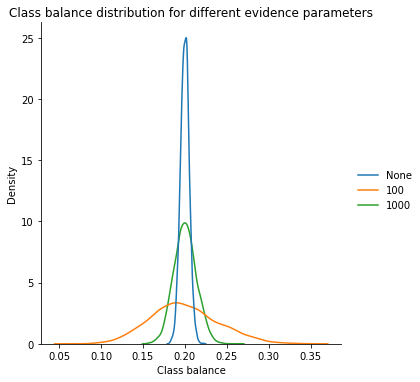

In [12]:
# Simulating the class balance distribution

generator = BlobGenerator(
    train_size=5000,
    test_size=1000,
    weights=[0.8,0.2],
    random_imbalance=True,
    )

evidence = [None,100,1000]

balance_distr = {}
for e in evidence:
    if e is None:
        a, b = None, None
    else:
        a, b = int(e*0.8), int(e*0.2)
    balance_distr[str(e)] = sim_random_balance(
        generator, a, b, n_runs=5000)
sns.displot(pd.DataFrame(balance_distr), kind='kde').set(title='Class balance distribution for different evidence parameters')
plt.xlabel('Class balance')

Here we compute the distribution of the precision for several degrees of uncertainty in the class balance, for two dataset sizes

In [13]:
params = {
    'random_imbalance': True,
    'n_runs': 1000,
    'imbalance_prior_a': [None, 800, 80]*2,
    'imbalance_prior_b': [None, 200, 20]*2,
    'train_size' : [5000]*3 + [500]*3,
    'test_size' : [1000]*3 + [100]*3
}
results_rbal_size = run_params(params, 2, 'imbalance_datasize', comb_type='zip', save=True, verbose=True)

Varied parameter values:  {'imbalance_prior_a': [None, 800, 80, None, 800, 80], 'imbalance_prior_b': [None, 200, 20, None, 200, 20], 'train_size': [5000, 5000, 5000, 500, 500, 500], 'test_size': [1000, 1000, 1000, 100, 100, 100]}
Constant parameter values:  {'random_imbalance': True, 'n_runs': 1000}
Combination 1 out of 6 being tried: [('imbalance_prior_a', None), ('imbalance_prior_b', None), ('train_size', 5000), ('test_size', 1000)]
Combination 2 out of 6 being tried: [('imbalance_prior_a', 800), ('imbalance_prior_b', 200), ('train_size', 5000), ('test_size', 1000)]
Combination 3 out of 6 being tried: [('imbalance_prior_a', 80), ('imbalance_prior_b', 20), ('train_size', 5000), ('test_size', 1000)]
Combination 4 out of 6 being tried: [('imbalance_prior_a', None), ('imbalance_prior_b', None), ('train_size', 500), ('test_size', 100)]
Combination 5 out of 6 being tried: [('imbalance_prior_a', 800), ('imbalance_prior_b', 200), ('train_size', 500), ('test_size', 100)]
Combination 6 out of 

<AxesSubplot:>

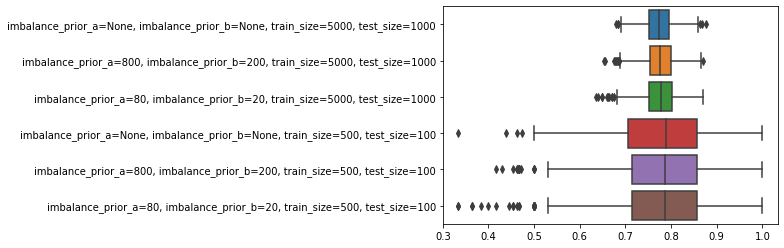

In [14]:
df = pd.DataFrame({k: cms_to_precision(v) for k, v in results_rbal_size.items()})
sns.boxplot(data=df,orient='h')

In [15]:
df_cols_levene(df)

,p-value levene's test,Variance 1,Variance 2
"imbalance_prior_a=None, imbalance_prior_b=None, train_size=5000, test_size=1000 vs imbalance_prior_a=800, imbalance_prior_b=200, train_size=5000, test_size=1000",0.762276,0.001147,0.001173
"imbalance_prior_a=None, imbalance_prior_b=None, train_size=5000, test_size=1000 vs imbalance_prior_a=80, imbalance_prior_b=20, train_size=5000, test_size=1000",0.007320,0.001147,0.001418
"imbalance_prior_a=None, imbalance_prior_b=None, train_size=5000, test_size=1000 vs imbalance_prior_a=None, imbalance_prior_b=None, train_size=500, test_size=100",0.000000,0.001147,0.012479
"imbalance_prior_a=None, imbalance_prior_b=None, train_size=5000, test_size=1000 vs imbalance_prior_a=800, imbalance_prior_b=200, train_size=500, test_size=100",0.000000,0.001147,0.011623
"imbalance_prior_a=None, imbalance_prior_b=None, train_size=5000, test_size=1000 vs imbalance_prior_a=80, imbalance_prior_b=20, train_size=500, test_size=100",0.000000,0.001147,0.013198
"imbalance_prior_a=800, imbalance_prior_b=200, train_size=5000, test_size=1000 vs imbalance_prior_a=80, imbalance_prior_b=20, train_size=5000, test_size=1000",0.017029,0.001173,0.001418
"imbalance_prior_a=800, imbalance_prior_b=200, train_size=5000, test_size=1000 vs imbalance_prior_a=None, imbalance_prior_b=None, train_size=500, test_size=100",0.000000,0.001173,0.012479
"imbalance_prior_a=800, imbalance_prior_b=200, train_size=5000, test_size=1000 vs imbalance_prior_a=800, imbalance_prior_b=200, train_size=500, test_size=100",0.000000,0.001173,0.011623
"imbalance_prior_a=800, imbalance_prior_b=200, train_size=5000, test_size=1000 vs imbalance_prior_a=80, imbalance_prior_b=20, train_size=500, test_size=100",0.000000,0.001173,0.013198
"imbalance_prior_a=80, imbalance_prior_b=20, train_size=5000, test_size=1000 vs imbalance_prior_a=None, imbalance_prior_b=None, train_size=500, test_size=100",0.000000,0.001418,0.012479


What happens to the effect of random class balance if we increase the complexity of class separation by decreasing the distance between the blob centers?

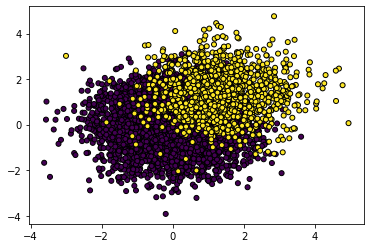

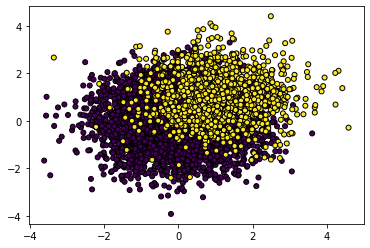

In [16]:
generator = BlobGenerator(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    class_d=1,
    random_state=123
)
X, y = generator.make_classification()
generator.plot_blobs(X, y, scatter=True, contour=False)

generator = BlobGenerator(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    class_d=1.5,
    random_state=123
)
X, y = generator.make_classification()
generator.plot_blobs(X, y, scatter=True, contour=False)


In [17]:
params = {
    'random_imbalance': True,
    'n_runs': 1000,
    'imbalance_prior_a': [None, 800, 80]*2,
    'imbalance_prior_b': [None, 200, 20]*2,
    'class_d' : [1]*3 + [1.5]*3
}
results_rbal_classd = run_params(
    params, 3, 'imbalance_datasize', comb_type='zip', save=True, verbose=True)

Varied parameter values:  {'imbalance_prior_a': [None, 800, 80, None, 800, 80], 'imbalance_prior_b': [None, 200, 20, None, 200, 20], 'class_d': [1, 1, 1, 1.5, 1.5, 1.5]}
Constant parameter values:  {'random_imbalance': True, 'n_runs': 1000}
Combination 1 out of 6 being tried: [('imbalance_prior_a', None), ('imbalance_prior_b', None), ('class_d', 1)]
Combination 2 out of 6 being tried: [('imbalance_prior_a', 800), ('imbalance_prior_b', 200), ('class_d', 1)]
Combination 3 out of 6 being tried: [('imbalance_prior_a', 80), ('imbalance_prior_b', 20), ('class_d', 1)]
Combination 4 out of 6 being tried: [('imbalance_prior_a', None), ('imbalance_prior_b', None), ('class_d', 1.5)]
Combination 5 out of 6 being tried: [('imbalance_prior_a', 800), ('imbalance_prior_b', 200), ('class_d', 1.5)]
Combination 6 out of 6 being tried: [('imbalance_prior_a', 80), ('imbalance_prior_b', 20), ('class_d', 1.5)]


<AxesSubplot:>

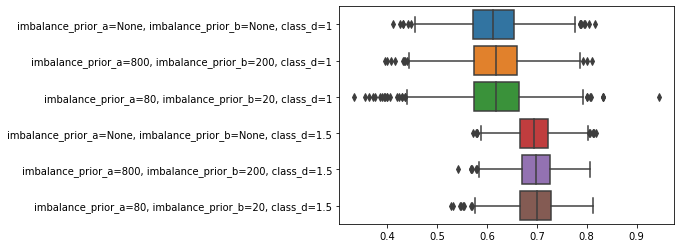

In [18]:
df = pd.DataFrame({k: cms_to_precision(v) for k, v in results_rbal_classd.items()})
sns.boxplot(data=df,orient='h')

In [19]:
df_cols_levene(df)

,p-value levene's test,Variance 1,Variance 2
"imbalance_prior_a=None, imbalance_prior_b=None, class_d=1 vs imbalance_prior_a=800, imbalance_prior_b=200, class_d=1",0.289138,0.004273,0.004510
"imbalance_prior_a=None, imbalance_prior_b=None, class_d=1 vs imbalance_prior_a=80, imbalance_prior_b=20, class_d=1",0.002989,0.004273,0.005656
"imbalance_prior_a=None, imbalance_prior_b=None, class_d=1 vs imbalance_prior_a=None, imbalance_prior_b=None, class_d=1.5",0.000000,0.004273,0.001775
"imbalance_prior_a=None, imbalance_prior_b=None, class_d=1 vs imbalance_prior_a=800, imbalance_prior_b=200, class_d=1.5",0.000000,0.004273,0.001821
"imbalance_prior_a=None, imbalance_prior_b=None, class_d=1 vs imbalance_prior_a=80, imbalance_prior_b=20, class_d=1.5",0.000000,0.004273,0.002124
"imbalance_prior_a=800, imbalance_prior_b=200, class_d=1 vs imbalance_prior_a=80, imbalance_prior_b=20, class_d=1",0.045300,0.004510,0.005656
"imbalance_prior_a=800, imbalance_prior_b=200, class_d=1 vs imbalance_prior_a=None, imbalance_prior_b=None, class_d=1.5",0.000000,0.004510,0.001775
"imbalance_prior_a=800, imbalance_prior_b=200, class_d=1 vs imbalance_prior_a=800, imbalance_prior_b=200, class_d=1.5",0.000000,0.004510,0.001821
"imbalance_prior_a=800, imbalance_prior_b=200, class_d=1 vs imbalance_prior_a=80, imbalance_prior_b=20, class_d=1.5",0.000000,0.004510,0.002124
"imbalance_prior_a=80, imbalance_prior_b=20, class_d=1 vs imbalance_prior_a=None, imbalance_prior_b=None, class_d=1.5",0.000000,0.005656,0.001775


#### 3. Introducing label noise to the data. What is the effect on the distribution of the precision?

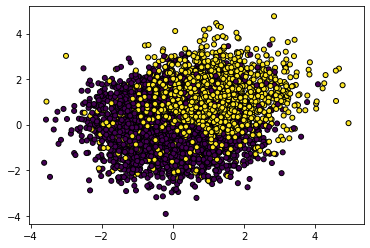

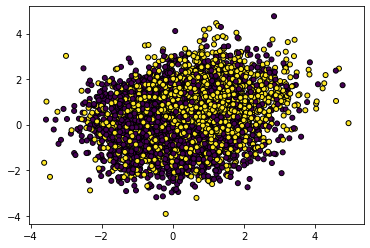

In [20]:
generator = BlobGenerator(
    train_size=5000,
    test_size=1000,
    weights=[0.8,0.2],
    flip_y=0.1,
    random_state=123,
    )
X, y = generator.make_classification()
generator.plot_blobs(X, y, scatter=True, contour=False)

generator = BlobGenerator(
    train_size=5000,
    test_size=1000,
    weights=[0.8,0.2],
    flip_y=0.3,
    random_state=123)
X, y = generator.make_classification()
generator.plot_blobs(X, y, scatter=True, contour=False)


In [21]:
params = {
    'n_runs' : 1000,
    'flip_y' : [0,0.05,0.1,0.2]
}

results_yflip = run_params(params,4,'label','zip',save=True,verbose=True)

Varied parameter values:  {'flip_y': [0, 0.05, 0.1, 0.2]}
Constant parameter values:  {'n_runs': 1000}
Combination 1 out of 4 being tried: [('flip_y', 0)]
Combination 2 out of 4 being tried: [('flip_y', 0.05)]
Combination 3 out of 4 being tried: [('flip_y', 0.1)]
Combination 4 out of 4 being tried: [('flip_y', 0.2)]


,p-value levene's test,Variance 1,Variance 2
flip_y=0 vs flip_y=0.05,0.556167,0.001124,0.001192
flip_y=0 vs flip_y=0.1,0.005332,0.001124,0.001380
flip_y=0 vs flip_y=0.2,0.000000,0.001124,0.001727
flip_y=0.05 vs flip_y=0.1,0.029646,0.001192,0.001380
flip_y=0.05 vs flip_y=0.2,0.000000,0.001192,0.001727
flip_y=0.1 vs flip_y=0.2,0.002186,0.001380,0.001727


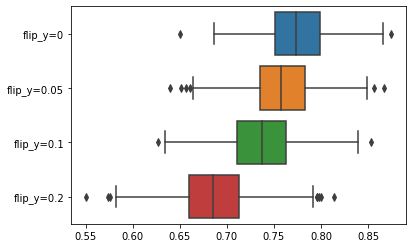

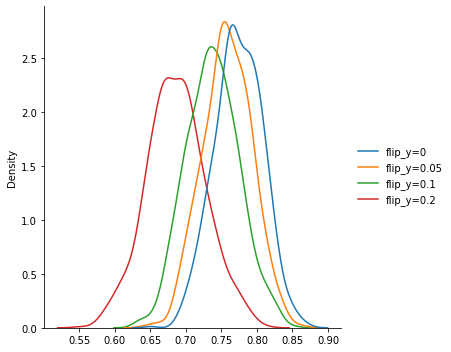

In [22]:
df = pd.DataFrame(CM_dict_to_prec(results_yflip))
sns.boxplot(data=df,orient = 'h')
sns.displot(df,kind='kde')

df_cols_levene(df)

#### All noise components combined, comparison

In [23]:
params = {
    'flip_y':[0.1],
    'random_imbalance':[True],
    'n_runs' : 1000
}

results_combined = run_params(params,5,'combined','zip')

Varied parameter values:  {'flip_y': [0.1], 'random_imbalance': [True]}
Constant parameter values:  {'n_runs': 1000}


<AxesSubplot:>

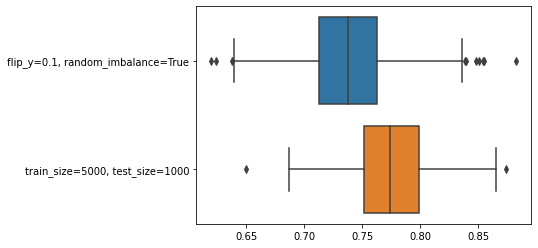

In [24]:
# sns.boxplot(data=cms_to_precision(results_smpl['train_size=5000, test_size=1000']))

results_combined.update({
    'train_size=5000, test_size=1000': results_smpl['train_size=5000, test_size=1000']})
sns.boxplot(data=pd.DataFrame(CM_dict_to_prec(results_combined)),orient='h')


In [14]:
df_cols_levene(pd.DataFrame(CM_dict_to_prec(results_combined)))


NameError: name 'results_combined' is not defined

Comparison for different types of noise

#### 4. Consider now two models with non-deterministic training: XGBoost and a neural net (MLP), what is the distribution of the precision on a single dataset due to non-deterministic training?

In [6]:
def sim_nd_train_prec(train_size, test_size, weights, model_name, n_runs, nd_train = True, flip_y=0, random_imbalance=False, gen_seed=123, tau=0.5, n_jobs=1):
    generator = BlobGenerator(
        train_size=train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        random_imbalance=random_imbalance,
        random_state=gen_seed,
    )
    LA = LAlgorithm(model_name, generator, nd_train=nd_train)
    cms = LA.repeat_nd_train(n_runs, data_seed=gen_seed,
                             tau=tau, n_jobs=n_jobs)
    precs = LA._cms_to_precision(cms)
    return precs

In [7]:
params = {
    'fixed_data' : True,
    'data_seed' : 1,
    'n_runs' : 1000,
    'model_name': ['LR', 'NN', 'XGB']
}

results_ndtrain = run_params(params,6,'nd_train','zip')

Varied parameter values:  {'model_name': ['LR', 'NN', 'XGB']}
Constant parameter values:  {'fixed_data': True, 'data_seed': 1, 'n_runs': 1000}


C:\Users\coenv\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 6.79999999999999, 'Precision')

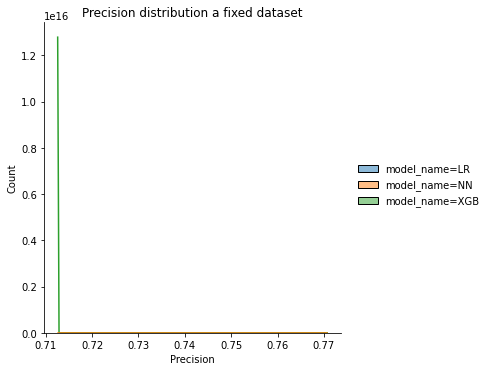

In [8]:
df = pd.DataFrame(CM_dict_to_prec(results_ndtrain))
sns.displot(df,kde=True)
plt.title('Precision distribution a fixed dataset')
plt.xlabel('Precision')

<AxesSubplot:>

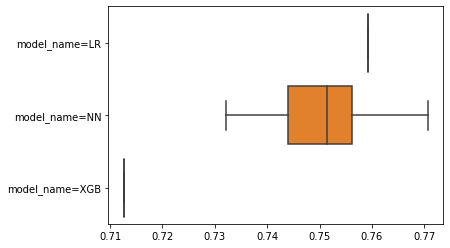

In [9]:
sns.boxplot(data=df,orient='h')

#### 5. Uncertainty for LR, XGB and NN for random train/test draw

In [10]:
# Without additional noise components

params = {
    'random_state' : 123,
    'n_runs' : 1000,
    'model_name': ['LR', 'NN', 'XGB']
}

results_cleanmodels = run_params(params,6,'cleanmodels','zip')

Varied parameter values:  {'model_name': ['LR', 'NN', 'XGB']}
Constant parameter values:  {'random_state': 123, 'n_runs': 1000}


,p-value levene's test,Variance 1,Variance 2
model_name=LR vs model_name=NN,0.973250,0.001161,0.001180
model_name=LR vs model_name=XGB,0.524871,0.001161,0.001273
model_name=NN vs model_name=XGB,0.508858,0.001180,0.001273


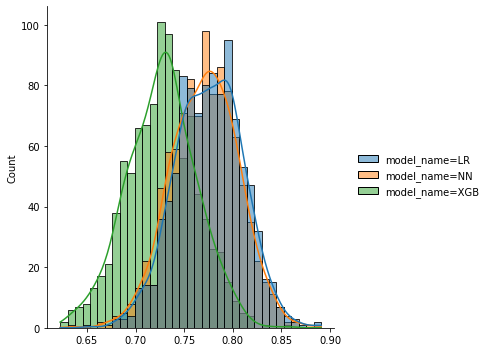

In [11]:
df = pd.DataFrame(CM_dict_to_prec(results_cleanmodels))
sns.displot(df,kde=True)

df_cols_levene(df)

In [12]:
# With additional noise components

params = {
    'random_imbalance' : True,
    'flip_y' : 0.1,
    'random_state' : 1,
    'n_runs' : 1000,
    'model_name': ['LR', 'NN', 'XGB']
}

results_noisymodels = run_params(params,6,'cleanmodels','zip')

Varied parameter values:  {'model_name': ['LR', 'NN', 'XGB']}
Constant parameter values:  {'random_imbalance': True, 'flip_y': 0.1, 'random_state': 1, 'n_runs': 1000}


,p-value levene's test,Variance 1,Variance 2
model_name=LR vs model_name=NN,0.735397,0.001419,0.001433
model_name=LR vs model_name=XGB,0.523890,0.001419,0.001481
model_name=NN vs model_name=XGB,0.760264,0.001433,0.001481


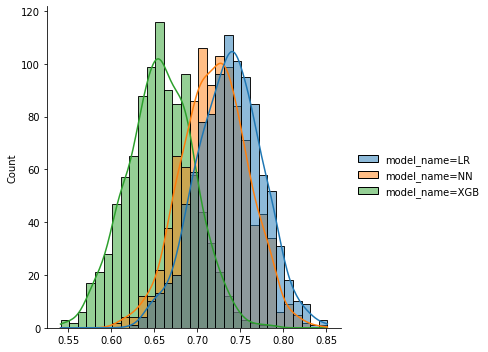

In [13]:
df = pd.DataFrame(CM_dict_to_prec(results_noisymodels))
sns.displot(df,kde=True)
df_cols_levene(df)

#### 6. Investigating the differences in variance for a NN depending on data sample

In [ ]:
def sim_var_prec_nd(train_size, test_size, weights, flip_y, random_imbalance, gen_seed, model_name, fix_init, n_runs, n_sets, tau=0.5, parallel=False):
    generator = BlobGenerator(
        train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        random_imbalance=random_imbalance,
        random_state=gen_seed,
    )
    LA = LAlgorithm(model_name, generator, fix_init=fix_init)
    stds = LA.sim_prec_std(n_sets, n_runs, parallel=parallel)
    return stds


def sim_iv_prec_nd(train_size, test_size, weights, flip_y, random_imbalance, gen_seed, model_name, fix_init, n_runs, n_sets, qrange=0.95, tau=0.5, parallel=False):
    generator = BlobGenerator(
        train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        random_imbalance=random_imbalance,
        random_state=gen_seed,
    )
    LA = LAlgorithm(model_name, generator, fix_init=fix_init)
    iv_lens = LA.sim_prec_iv(n_sets, n_runs, qrange, parallel, n_jobs=15)
    return iv_lens


In [24]:
train_size = 5000
test_size = 1000
weights = [0.8, 0.2]
n_runs = 100
n_sets = 100
flip_y = 0
random_imbalance = False
fix_init = False
model_name = 'NN'
gen_seed = 12

iv_lens = sim_iv_prec_nd(
    train_size,
    test_size,
    weights,
    flip_y,
    random_imbalance,
    gen_seed,
    model_name,
    fix_init,
    n_runs,
    n_sets,
    qrange=0.95,
    tau=0.5,
    parallel=True)


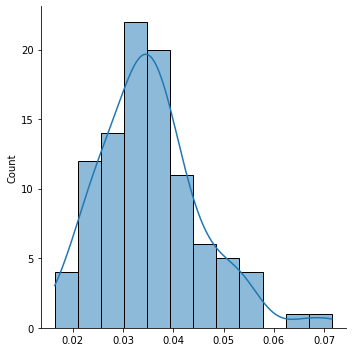

In [25]:
sns.displot(iv_lens, kde=True)


#### To be continued

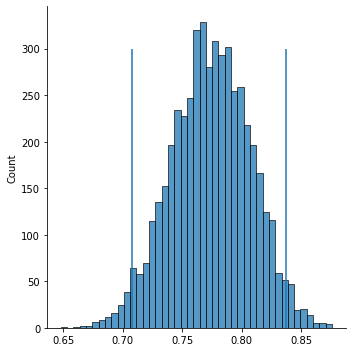

In [47]:
# np.quantile(precs0,0.9)
# sns.displot(precs1)
# plt.vlines([np.quantile(precs1,0.025),np.quantile(precs1,0.975)],ymin=0,ymax=300)


In [62]:
# # %% First we simulate the true CM distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size
# #This is the same as the true distribution of a holdout estimator
# train_size = 1000
# test_frac = 1/5
# weights = [0.8,0.2]
# n_sets = 100
# random_imbalance = False
# flip_y = 0

# model_name = 'LR'
# fix_init = True

# repeats = 10

# def simulate_cms(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,random_state,train_seed=0):
#     data_dict = f.generate_blobs(train_size = train_size,test_size=int(test_frac*train_size),n_sets=n_sets,
#                                 random_state = random_state,flip_y=flip_y,weights = weights,random_imbalance=random_imbalance)
#     return f.holdout_CM(model_name,data_dict,train_seed,fix_init=fix_init)

# cms = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))

# # precisions
# TP = cms[:,1,1]
# FP = cms[:,0,1]
# precs = TP/(TP+FP)

# #recalls
# FN = cms[:,1,0]
# recs = TP/(TP+FN)


Here I experiment with different weight splits, to observe the effect on 3 models: Logistic regression, neural network and Gradient Boosting

In [144]:
# # %% First we simulate the true CM distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size
# #This is the same as the true distribution of a holdout estimator

# def flatten(t):
#     return [item for sublist in t for item in sublist]

# def simulate_distr(model_names, weight_splits,train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,repeats):
#     precs_list = []
#     recs_list = []
#     col_model = []
#     col_balance = []

#     for model_name in model_names:
#         for w in weight_splits:
#             weights = [1-w,w]
#             cms = np.vstack(Parallel(n_jobs=-1,verbose = 1)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#                 fix_init,random_state=seed_i) for seed_i in range(repeats)))

#             # precisions
#             TP = cms[:,1,1]
#             FP = cms[:,0,1]
#             precs = TP/(TP+FP)

#             #recalls
#             FN = cms[:,1,0]
#             recs = TP/(TP+FN)
#             precs_list.append(precs.tolist())
#             recs_list.append(recs.tolist())
#             col_model.append(np.repeat(model_name,n_sets*repeats).tolist())
#             col_balance.append(np.repeat(w,n_sets*repeats).tolist())
#     results = {'precision': flatten(precs_list), 'recall':flatten(recs_list),'model':flatten(col_model),'balance':flatten(col_balance)}
#     return results


In [173]:
# model_names = ['LR','NN','GB']
# # weight_splits = [0.1,0.3,0.5]
# train_sizes = [100,200,300]

# train_size = 1000
# test_frac = 1/5
# n_sets = 10
# random_imbalance = True
# # flip_y = 0
# fix_init = True
# repeats = 1000

# for flip_y in [0.05,0.1,0.2]:

#     filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
#     plot_dir = 'c:/Users/coenv/Documents/internship/ING/Thesis/code/ModelMetricUncertaintyResearch/results'

#     results = simulate_distr(model_names, weight_splits,train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,repeats)

#     pd.DataFrame(results).to_csv(plot_dir + filename +'.csv')


First consider only the noise introduced due to random class balance. First we fix the (mean) balance at 0.3, and set the train size at 1000. Consider a Logistic Regression model

In [61]:
# train_size = 500
# test_frac = 1/5
# weights = [0.7,0.3]
# n_sets = 1
# flip_y = 0

# model_name = 'LR'
# fix_init = True

# repeats = 1000

# random_imbalance = False
# cms0 = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))

# random_imbalance = True
# cms0 = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))


In [172]:
# plot_dir = 'c:/Users/coenv/Documents/internship/ING/Thesis/code/ModelMetricUncertaintyResearch/results'

# train_size = 1000
# test_frac = 1/5
# n_sets = 10
# random_imbalance = False
# flip_y = 0
# fix_init = True
# repeats = 1000
# filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
# df_0 = pd.read_csv(plot_dir + filename +'.csv')

# train_size = 1000
# test_frac = 1/5
# n_sets = 10
# random_imbalance = True #random imbalance included
# flip_y = 0
# fix_init = True
# repeats = 1000
# filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
# df_1 = pd.read_csv(plot_dir + filename +'.csv')


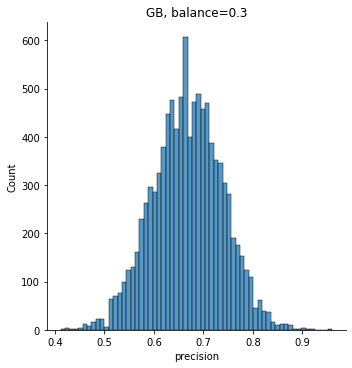

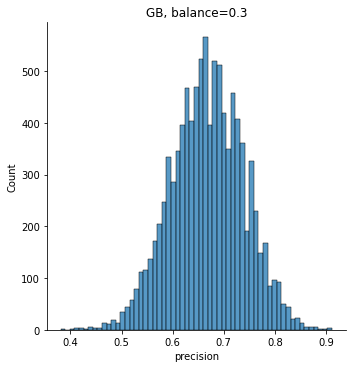

In [171]:
# # df_0 = pd.DataFrame(results)
# # sns.displot(df_0,x = 'precision',hue = 'model',col = 'balance',kde=True)
# # df_0.to_csv('results0.csv')
# # df
# def make_plot(df,model,balance,metric='precision'):
#     df_slice = df[(df['balance']==balance)& (df['model']==model)]
#     sns.displot(data=df_slice,x=metric)
#     plt.title(' '.join([model + ',','balance=' + str(balance)]))
# # sns.displot(data = df_0[(df_0['balance']==0.3)&(df_0['model']=='LR')],x = 'precision')
# # plt.title(' '.join(['LR,','balance=' + str(0.3)]))

# # make_plot(df_0,'LR',0.1,metric='recall')
# make_plot(df_0,'GB',0.3,metric='precision')
# make_plot(df_1,'GB',0.3,metric='precision')
# # make_plot(df_0,'LR',0.5,metric='recall')


In [84]:
# pd.DataFrame(np.array(precs_list).T)
# np.array(precs_list).flatten().shape
# col_model = np.repeat(model_names,repeats*n_sets*len(weight_splits)).shape
# col_balance =
# # cms.shape


(600,)

In [6]:
# import matplotlib.cm as cm

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# H, xedges, yedges= np.histogram2d(precs,recs)


# xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
# xpos = xpos.ravel()
# ypos = ypos.ravel()
# zpos = 0

# # Construct arrays with the dimensions for the 16 bars.
# dx = dy = 0.5 * np.ones_like(zpos)
# dz = H.ravel()

# cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
# max_height = np.max(dz)   # get range of colorbars so we can normalize
# min_height = np.min(dz)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap((k-min_height)/max_height) for k in dz]

# ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',color = rgba)

# plt.show()


Retrieving the true precisions and recalls

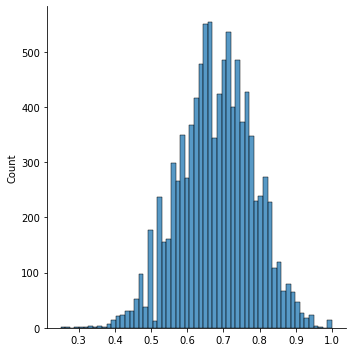

In [19]:
# # precs
# TP = cms[:,1,1]
# FP = cms[:,0,1]
# precs = TP/(TP+FP)

# #recs
# FN = cms[:,1,0]
# recs = TP/(TP+FN)

# sns.displot(precs)


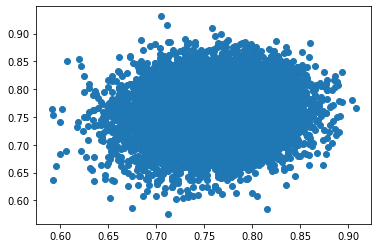

In [8]:
# plt.scatter(precs,recs)


Method by Caelen (2017), multinomial likelihood with Dirichlet priors

In [28]:
# #Given an observed CM, compute the distribution of a performance metric by MC-sampling
# from numpy.random import default_rng

# theta_prior = np.ones(4)
# rng = default_rng(0)
# cm = cms[0]

# def sample_CM(v,theta_prior):
#     theta_post = rng.dirichlet(alpha = v + theta_prior)
#     cm = rng.multinomial(n = v.sum(), pvals = theta_post) # pakketten die dit sneller doen
#     return cm.tolist()

# def sample_CM_N(v,theta_prior,MC_N=1000):
#     CL_cms = np.zeros((MC_N,4),dtype = int)
#     for i in range(MC_N):
#         CL_cms[i] = sample_CM(v,theta_prior)
#     return CL_cms

# def prec_from_CMs(cms):
#     TP = cms[:,-1]
#     FP = cms[:,1]
#     return TP/(TP+FP)

# def rec_from_CMs(cms):
#     TP = cms[:,-1]
#     FN = cms[:,-2]
#     return TP/(TP+FN)


In [37]:
# cms_CA = sample_CM_N(cm.flatten(),theta_prior,MC_N=1000)
# Cae_precs = []

# for cm in cms[:3]:
#     cms_CA = sample_CM_N(cm.flatten(),theta_prior,MC_N=1000)
#     Cae_precs.append(prec_from_CMs(cms_CA))


C:\Users\coenv\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\coenv\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of precision')

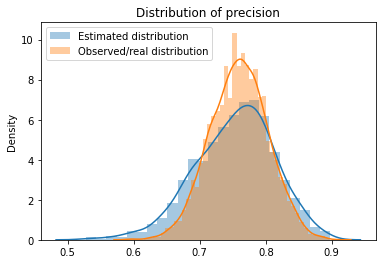

In [47]:
# sns.distplot(Cae_precs[2], label = 'Estimated distribution')
# sns.distplot(precs, label = 'Observed/real distribution')
# plt.legend()
# plt.title('Distribution of precision')

# #TODO: Calculate the coverage and size of confidence intervals created by Caelen's method


In [9]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import confusion_matrix

# def CM_cv(X,y,test_frac,model_name,seed=0,fix_train = False):
#     kf = KFold(n_splits = int(1/test_frac)+1)
#     LA = LAlgorithm(model_name)
#     cms = []
#     for train_index, test_index in kf.split(X):
#         if not fix_train:
#             seed+=1
#         model = LA.init_model(random_state = seed) #initialize model
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         model.fit(X_train,y_train)
#         y_pred = model.predict(X_test)
#         cms.append(confusion_matrix(y_test,y_pred).tolist())
#     return cms


In [10]:
# data_dict = f.generate_blobs(train_size = 1000,test_size=200,n_sets=n_sets,random_state = 1,flip_y=0.1)
# X,y = f.unpack_data_dict(data_dict,stack = True)
# cms_cv = CM_cv(X[0],y[0],test_frac,model_name)
# np.array(cms_cv)


array([[[81, 19],
        [37, 63]],

       [[73, 22],
        [31, 74]],

       [[67, 32],
        [27, 74]],

       [[77, 28],
        [17, 78]],

       [[78, 35],
        [28, 59]],

       [[68, 27],
        [31, 74]]])

In [66]:
# CM_cv(X_train[0],y,test_frac,seed,model_name,fix_train = False)


(1000, 1000, 2)

Firstly, consider the case where we have only a single train-test run. This is equivalent to a holdout estimator. 
To obtain a confidence interval we need to evaluate the variance of this estimator. 

This can be done by:
1.  assuming a binomial distribution on the precision/recall and using a normal approximation for the confidence interval

In [6]:
# # %% To obtain a confidence interval of the expected precision we need to evaluate the variance of the holdout estimator. This can be done by assuming
# #a binomial distribution and using a normal approximation for the confidence interval
# n_pos = out[:,2,:].flatten()

# l = true_precs - 1.96*np.sqrt((true_precs * (1-true_precs))/n_pos)
# u = true_precs + 1.96*np.sqrt((true_precs * (1-true_precs))/n_pos)

# #fraction of confidence intervals that cover the true population parameter value
# print(np.mean((l<EP_prec) & (EP_prec<u)))

# #We observe that the confidence interval is approximately correct, it covers the true mean in about 94 percent of the cases.

# #Save the widths to compare with the other methods
# holdout_CI_width = u-l


0.9378


2. bootstrapping both train and test

In [56]:
# from numpy.random import default_rng

# def bootstrap_sample(learn_algo,data_dict,seed=0,fix_init=False):
#     rng = default_rng(seed)

#     X_train = data_dict['train']['X']
#     y_train = data_dict['train']['y']
#     X_test = data_dict['test']['X']
#     y_test = data_dict['test']['y']

#     X = np.hstack([X_train, X_test])
#     y = np.hstack([y_train, y_test])

#     n_obs = y.shape[1]
#     bs_indices = rng.integers(0,high = n_obs,size = y.shape)

#     X_bs = np.zeros(X.shape)
#     y_bs = np.zeros(y.shape)

#     for i in range(len(y_bs)):
#         X_bs[i] = X[i][bs_indices[i]]
#         y_bs[i] = y[i][bs_indices[i]]

#     train_size = y_train.shape[1]

#     X_train = X_bs[:,:train_size,:]
#     X_test = X_bs[:,train_size:,:]
#     y_train = y_bs[:,:train_size,:]
#     y_test = y_bs[:,train_size:,:]

#     return X_train,X_test,y_train,y_test


# def bootstrap_prec_rec(learn_algo,data_dict,seed=0,fix_init=False):
#     X_train,X_test,y_train,y_test = bootstrap_sample(learn_algo,data_dict,seed=0,fix_init=False)

#     if fix_init:
#         train_seed = 0
#     else:
#         train_seed = seed
#     LA = LAlgorithm(learn_algo)

#     precs = []
#     recs = []
#     n_pos = []
#     for i in range(len(y_train)):
#         model = LA.init_model(random_state=train_seed+i)
#         model.fit(X_train[i],y_train[i])
#         y_pred = model.predict(X_test[i])

#         n_pos.append(np.sum(y_pred==1))
#         precs.append(precision_score(y_test[i],y_pred))
#         recs.append(recall_score(y_test[i],y_pred))


IndentationError: expected an indented block (4180208275.py, line 39)

In [52]:


# rng = default_rng(1)
# n_obs = train_size + int(train_size * test_frac)
# data_dict['train']['y'][0]
# data_dict['train']['X']
# bs_indices = rng.integers(0,high = n_obs,size = y.shape)

# X = np.hstack([data_dict['train']['X'], data_dict['test']['X']])
# y = np.hstack([data_dict['train']['y'], data_dict['test']['y']])

# bs_indices

# X_bs = np.zeros(X.shape)
# y_bs = np.zeros(y.shape)

# for i in range(len(y_bs)):
#     X_bs[i] = X[i][bs_indices[i]]
#     y_bs[i] = y[i][bs_indices[i]]


In [55]:
# bs_indices[0]


array([567, 614, 906, ..., 421, 304, 461], dtype=int64)

In [34]:
# data_dict['test']['X'][0].shape
# np.vstack([data_dict['train']['X'][0],data_dict['test']['X'][0]]).shape


(1200, 2)

3. We can use the Bayesian method by Caelen (2017); use a Multinomial likelihood for the confusion matrix and a Dirichlet prior on the probabilities

In [15]:
# cms = Parallel(n_jobs = -1,verbose = 5)(delayed(f.holdout_CM)(model_name,train_size,test_frac,n_sets=n_sets,seed=seed_i) for seed_i in range(repeats))
# cms = np.vstack(cms)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.3min finished
